In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

<ipython-input-2-f0b9b9dbb707>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XTrain = torch.tensor(X,dtype=torch.float32)
<ipython-input-2-f0b9b9dbb707>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yTrain = torch.tensor(Y,dtype=torch.float32)


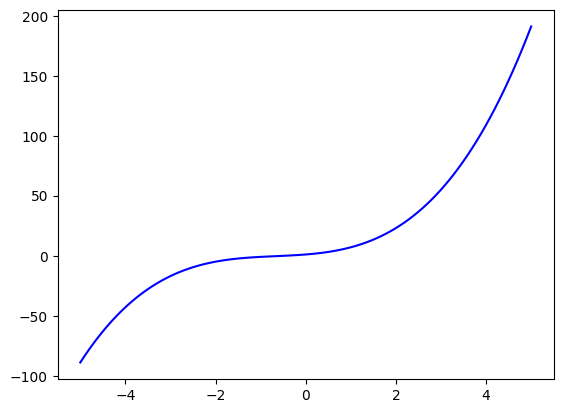

In [2]:
def nlfunction(x):
    return (x**3 + 2*x**2 + 3*x + 1)
X = torch.linspace(-5, 5, 100).unsqueeze(1)
Y = nlfunction(X)
XTrain = torch.tensor(X,dtype=torch.float32)
yTrain = torch.tensor(Y,dtype=torch.float32)
XTrain = XTrain.view(XTrain.shape[0],1)
yTrain = yTrain.view(yTrain.shape[0],1)
plt.plot(X,Y,'b')

In [3]:
class Model1(nn.Module):
   def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 1)
   def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = F.relu(self.fc3(val))
        val = self.fc4(val)
        return val

In [4]:
model1 = Model1()
summary(model1,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 60]             120
            Linear-2                   [-1, 40]           2,440
            Linear-3                   [-1, 20]             820
            Linear-4                    [-1, 1]              21
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [5]:
lossFunc = nn.MSELoss()
opt = optim.Adam(model1.parameters(), lr=0.001)

In [6]:
# train the model
minRatios = []
losses = []
for i in range(100):
    output = model1(XTrain)
    loss = lossFunc(output, yTrain)
    opt.zero_grad()
    loss.backward()
    if (i+1)%10 == 0:
        print(f'Epoch : {i+1} Loss: {loss.item(): .3f}')

    with torch.no_grad():
        minRatio = float("inf")
        for name, param in model1.named_parameters():
            if not param.requires_grad:
                continue
            paramGrad = param.grad.reshape(-1)
            hessian = torch.zeros((paramGrad.shape[0], paramGrad.shape[0]))
            for j, grad_j in enumerate(paramGrad):
                grad_j.requires_grad_()
                gradOutput = torch.autograd.grad(grad_j, param, retain_graph=True, create_graph=True,allow_unused=True)[0]
                if(gradOutput is not None):
                    gradOutput = gradOutput.reshape(-1)
                    hessian[j] = gradOutput
            eigenVals, _ = torch.linalg.eig(hessian)
            eigenVals = eigenVals.abs()
            minRatio = min(minRatio, param.abs().min().item() / (eigenVals.max().item() + 1e-7))
        minRatios.append(minRatio)
        losses.append(loss.item())

    opt.step()


Epoch : 10 Loss:  3763.043
Epoch : 20 Loss:  3730.464
Epoch : 30 Loss:  3678.763
Epoch : 40 Loss:  3600.220
Epoch : 50 Loss:  3482.766
Epoch : 60 Loss:  3316.887
Epoch : 70 Loss:  3099.613
Epoch : 80 Loss:  2838.562
Epoch : 90 Loss:  2547.414
Epoch : 100 Loss:  2228.605


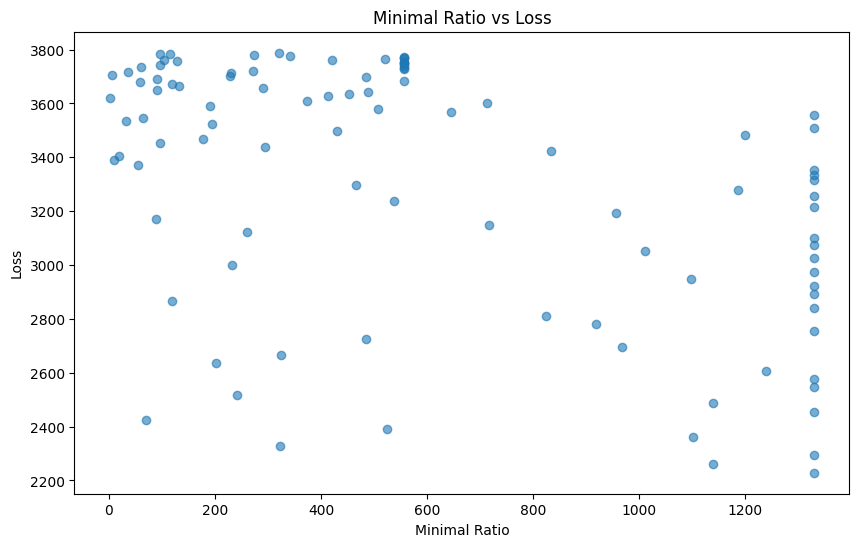

In [7]:
plt1 = plt.figure(figsize=(10, 6))
plt.scatter(minRatios, losses,alpha=0.6)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.title('Minimal Ratio vs Loss')
plt.show()